# Geocentric Model

Pada dasarnya beberapa model yang diterapkan pada sains tidak cukup untuk menjelaskan segala fenomena yang berkaitan. Pada bab ini, penulis berargumen bahwa model bumi sebagai pusat tata surya adalah sebuah model yang salah tetapi tetap mampu mendeskripsikan hal-hal dasar seperti pergerakan benda benda langit. Hal ini juga terjadi dalam statistik. Penulis beranggapan penggunaan regresi linear sama seperti model bumi sebagai pusat tata surya; tidak benar tapi masih dapat beguna untuk beberapa hal. 

Mengetahui batasan-batasan yang dapat ditangani sebuah model akan membuat model tersebut berguna dengan meminimalisasi penyalahgunaan. Mungkin dalam dunia fisika, ini sama dengan anggapan gravitasi adalah gaya tarik antar dua massa pada jarak tertentu. Sampai lahirnya teori relativitas, anggapan ini dianggap benar karena mampu menjelaskan banyak -- meski tak semua -- fenomena-fenomena benda langit.

Pada bab ini akan dikenalkan regresi linear menggunakan prosedur bayesian. 

## Distribusi Normal

Penulis menggunakan jalan acak untuk menunjukan bahwa distribusi normal muncul dimana-mana. Jalan acak ini memiliki aturan sebagai berikut, apabila hasil lemparan koin adalah gambar maka akan diberi nilai plus satu dan apabila hasil lemparan koin adalah angka maka akan diberi nilai minus satu. Misalkan ada 16 orang yang melakukan hal tersebut sebanyak delapan kali. Maka hasilnya dapat dilihat sebagai berikut

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


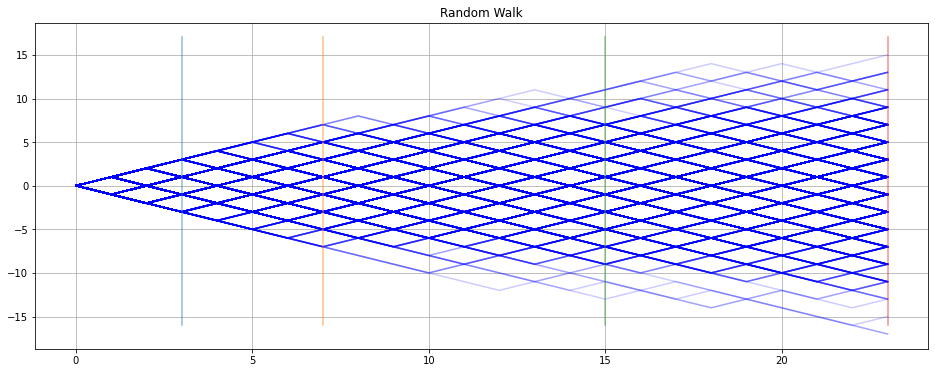

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import arviz as az
import requests
%matplotlib inline
total_participant = 16
total_step = 16


def generate_random_walk(total_step, total_participant):
    total_record = []
    for i in range(total_participant):
        step_record = []
        current_step = 0
        for j in range(total_step):
            step_record.append(current_step)
            coin_result = np.random.choice(["picture", "number"])
            if coin_result == "picture":
                current_step += 1
            else:
                current_step -= 1
        total_record.append(step_record)

    plt.figure(figsize=(16,6))
    for record in total_record:
        plt.plot(record, alpha=0.2, color='blue')
    plt.grid()
    plt.title("Random Walk")
    for i in [3, 7, 15, 23]:
        plt.plot([i,i], [-16, 17], alpha=.5)
    return total_record

total_record = generate_random_walk(24, 1024)

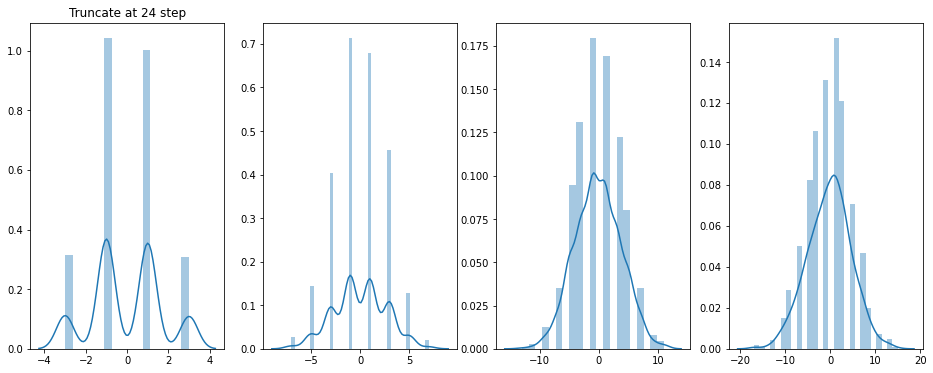

In [2]:
import seaborn as sns
fig, [ax1, ax2, ax3, ax4] = plt.subplots(nrows=1, ncols=4)
fig.set_figwidth(16)
fig.set_figheight(6)

ax1.title.set_text("Truncate at 4 step")
sns.distplot([i[3] for i in total_record], ax=ax1)

ax1.title.set_text("Truncate at 8 step")
sns.distplot([i[7] for i in total_record], ax=ax2)

ax1.title.set_text("Truncate at 16 step")
sns.distplot([i[15] for i in total_record], ax=ax3)

ax1.title.set_text("Truncate at 24 step")
sns.distplot([i[23] for i in total_record], ax=ax4)


Seperti yang dapat dilihat pada grafik diatas, saat langkah jalan acaknya semakin banyak, maka distirbusi hasil jalan acak tersebut akan semakin mendekati distribusi normal.
> Any process that adds together random values from the same distribution converges to
a normal

Ini adalah hasil distribusi normal dari penjumlahan, selain penjumlahan ada juga distribusi normal dari perkalian, perkalian log, dan distribusi gausian itu sendiri.

## Standarisasi Pemodelan

Ada beberapa properti dan prosedur dalam pemodelan. Meski pemodelan memiliki subjek yang berbeda, ada beberapa properti dalam abstraksi tertentu yang tetap sama. Memahami ini akan menjadi landasan pemodelan pemodalan statistik selanjutnya. Setidaknya ada tiga properti yang harus dipahami.

1. Mengenali variable yang akan dioperasikan/dimodelkan. Beberapa variabel dapat dipantau yang biasa disebut sebagai data dan ada variabel yang tidak dapat dipantau seperti rerata yang biasa disebut sebagai parameter.
2. Setiap varible yang terlibat dapat dideskripsikan sebgai distribusi atau gabungan dari variabel lain. Ini akan membangun asosiasi antar variabel
3. Kombinasi dari variabel dan distribusinya akan menghasilkan model generatif gabungan yang dapat-- dalam batasan tertentu -- mensimulasikan observasi hipotetikal dan menganalisis observasi yang sebenarnya.

Mengambil contoh sebelumnya, pada pelemparan bola bumi, digunakan dua distribusi yaitu binomial dan seragam. Secara matematik dapat ditulis

$$
\begin{align}
W  &\sim \text{Binomial}(N, p) \\
p  &\sim \text{Uniform}(0,1)
\end{align}
$$

Baris pertama dapat dibaca sebagai distribusi $W$ adalah distribusi binomial dengan percobaan sebanyak $N$ dan kemungkinan sebesar $p$. Baris kedua dapat dibaca sebagai distribusi $p$ adalah distribusi seragam dari nilai $0$ sampai dengan $1$.

In [3]:
# source https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv
df = pd.read_csv('HowellCh4.csv', sep=";")
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


Disajikan data yang memiliki empat buah kolom yaitu tinggi, berat, umur, dan jenis kelamin. Data tersebut dapat disimpulkan sebagai berikut

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
height,544.0,138.263596,27.602448,53.975000,125.095000,148.590000,157.480000,179.070000
weight,544.0,35.610618,14.719178,4.252425,22.007717,40.057844,47.209005,62.992589
age,544.0,29.344393,20.746888,0.000000,12.000000,27.000000,43.000000,88.000000
male,544.0,0.472426,0.499699,0.000000,0.000000,0.000000,1.000000,1.000000


In [5]:
df['height'].head()

0    151.765
1    139.700
2    136.525
3    156.845
4    145.415
Name: height, dtype: float64

In [6]:
df2 = df[df['age'] >= 18]

In [7]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
height,352.0,154.597093,7.742332,136.525000,148.59000,154.30500,160.655000,179.070000
weight,352.0,44.990486,6.456708,31.071052,40.25629,44.79221,49.292693,62.992589
age,352.0,41.138494,15.967855,18.000000,28.00000,39.00000,51.000000,88.000000
male,352.0,0.468750,0.499733,0.000000,0.00000,0.00000,1.000000,1.000000


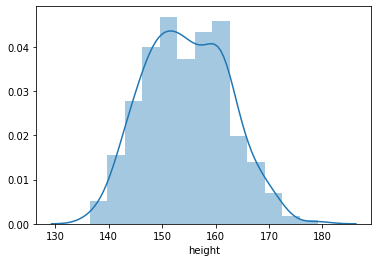

In [8]:
sns.distplot(df2['height'])

Disini dicari distribusi normal yang mewakili distribusi tinggi yang dihasilkan oleh data. Bentuk dari distribusi normal ditentukan rerata dan standar deviasi. Maka yang dicari adalah kombinasi suatu rerata dan suatu standar deviasi yang dapat mewakiliki distribusi tinggi.

$$ h_i \sim \text{Normal}(\mu, \sigma) \qquad i=1,2,3,\cdots,352$$

$i$ adalah anggota data kesekian. Dapat dilihat pada bagian kedua, $i$ dapat bernilai dari satu sampai degan 352 yang mana adalah total dari data yang tersedia. Agar dapat dioprasikan, model ini memerlukan prior untuk nilai $\mu$ dan $\sigma$. Nilai prior tersebut dapat ditulis

$$
\begin{align}
h_i &\sim \text{Normal}(\mu, \sigma) &[\text{Likelihood}]\\
\mu &\sim \text{Normal}(175, 20) &[\mu\; \text{prior}] \\
\sigma &\sim \text{Uniform}(0,50) &[\sigma\; \text{prior}]
\end{align}
$$

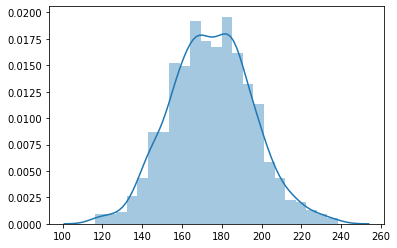

In [9]:
sns.distplot(np.random.normal(175, 20, size=1000))

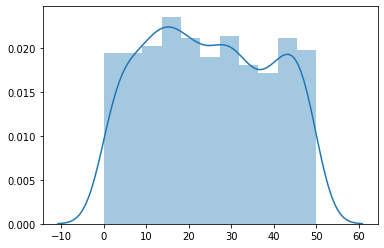

In [10]:
sns.distplot(np.random.uniform(0, 50, size=1000))

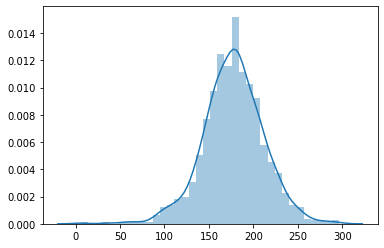

In [11]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)

sns.distplot(prior_h)

Berdasarkan plot diatas dapat dilihat distribusi dari prediksi prior. Pada distribusi tersebut masih ada orang yang memiliki tinggi lebih dari tiga meter. Prediksi prior digunakan untuk **memilah mana parameter prior yang baik untuk prediksi**. Dengan asumsi standar deviasi sebesar 20, distribusi masih ada terlihat kemungkinan orang yang memiliki tinggi 3 meter. Standar deviasi dapat diubah agar distribusi orang yang memiliki tinggi lebih besar dari 3 meter sangat kecil sekali. Sekarang akan dicoba apabila distribusi normal dengan standar deviasi sebesar 100.

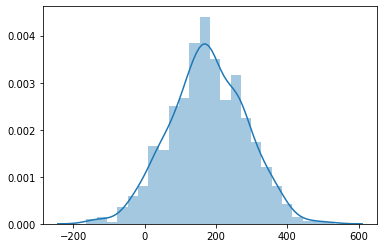

In [12]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=100, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)

sns.distplot(prior_h)

Dengan standari deviasi yang lebar, akan didapati tinggi dengan nilai minus dan masih terlihat kemungkinan orang yang memiliki tinggi lebih besar dari 4 meter. Dalam bukunya, Pak Richard menekankan kebutuhan pengetahuan dasar tentang model yang akan dibangun agar dapat memilih parameter prior yang baik. Dengan contoh kasus diatas, memilih standar deviasi sebesar 100 adalah sebuah kesalahan karena memungkinkan adanya orang yang memiliki tinggi kurang dari nol.
> Pada aggregasi distribusi diatas, `prior_h` dapat menerima array `sampe_mu` dan `sample_sigma` sebagai input rerata dan standar deviasi. Dalam perhitunganya, apakah yang terjadi pada masing-masing array? apakah direrata kan?

In [13]:
import numpy as np
asd = np.mgrid[150:160:.1, 7:9:1]

In [14]:
mu_list = np.linspace(150, 160, 101)
sigma_list = np.linspace(7, 9, 101)
mu_grid, sigma_grid = np.meshgrid(mu_list, sigma_list)
height = df["height"]
zipped = [mu_grid.reshape(-1), sigma_grid.reshape(-1)]
likelihood = [sum(stats.norm.logpdf(height, loc=zipped[0][i], scale=zipped[1][i])) for i in range(len(zipped[0]))]
post_prod = (likelihood + 
             stats.norm.logpdf(zipped[0], loc=178, scale=20) + 
             stats.uniform.logpdf(zipped[1], loc=0, scale=50))
post_prob = np.exp(post_prod - max(post_prod))
# likelihood = [sum(stats.norm.logpdf(d2.height, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]

Ada banyak yang harus dijelaskan dari kodingan diatas. Pertama adalah bagaimana `stats.norm.logpdf` berkerja.
`stats.norm.logpdf` memiliki input suatu array yang adalam kasus ini adalah `height`. Selanjutnya adalah menentukan rerata dan standar deviasi yang masing masing diwakili oleh key word argument `loc` dan `scale`. Selanjutnya akan dikembalikan array sebanyak array input yang pertama `height`. Isi dari balikan tersebut adalah kemungkinan nilai `height` muncul apabila ada distribusi normal yang memiliki rerata `loc` dan ber-standar deviasi `scale`.

Yang menjadi sedikit meta disini adalah saat memplotkan hasil dari `stats.norm.logpdf` sebagi plot distribusi. Plot distribusi ini menandakan seberapa cocok nilai rerata yang diajukan `loc` dan nilai standar deviasi `scale` terhadapt data yang dimiliki `height`.

Pada perhitungan likelihood, akan dicoba semua kombinasi yang memungkinkan antara rerata dan standar deviasi. Pada masing masing kombinasi tersebut akan digabungkan dengan sum. Penggunaan sum terjadi karena dari setiap hasil kombinasi tersebut dikalikan akan tetapi dikarenakan operaasi berlangsung pada logaritma, jadi menggunakan sum. Apabila fungsi yang digunakan `stats.norm.pdf` maka yang terjadi adalah menggunakan $\Pi$ bukan $\Sigma$. Ini dijelaskan pada bagian overthinking.

Suku kedua dan ketiga setelahnya adalah prior. `post_prob` adalah hasil dari penjumlahan tersebut yang dikurangi dengan nilai maksimum dari penjumlahan. Ini sebenernya adalah pembagian pada bayesian, tapi dikarenakan masih dalam konteks logaritma, maka operasinya pun menjadi pengurangan. 

In [15]:
post = np.mgrid[140:160:0.1, 4:9:0.1].reshape(2,-1).T

likelihood = [sum(stats.norm.logpdf(df2.height, loc=post[i,0], scale=post[i,1])) for i in range(len(post))]

post_prod = (likelihood + 
             stats.norm.logpdf(post[:,0], loc=178, scale=20) + 
             stats.uniform.logpdf(post[:,1], loc=0, scale=50))
post_prob = np.exp(post_prod - max(post_prod))

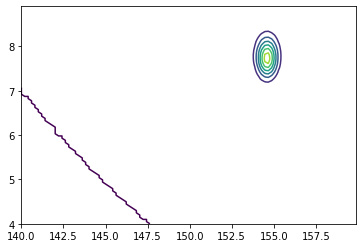

In [16]:
xi = np.linspace(post[:,0].min(), post[:,0].max(), 100)
yi = np.linspace(post[:,1].min(), post[:,1].max(), 100)
zi = griddata((post[:,0], post[:,1]), post_prob, (xi[None,:], yi[:,None]))
plt.contour(xi, yi, zi);

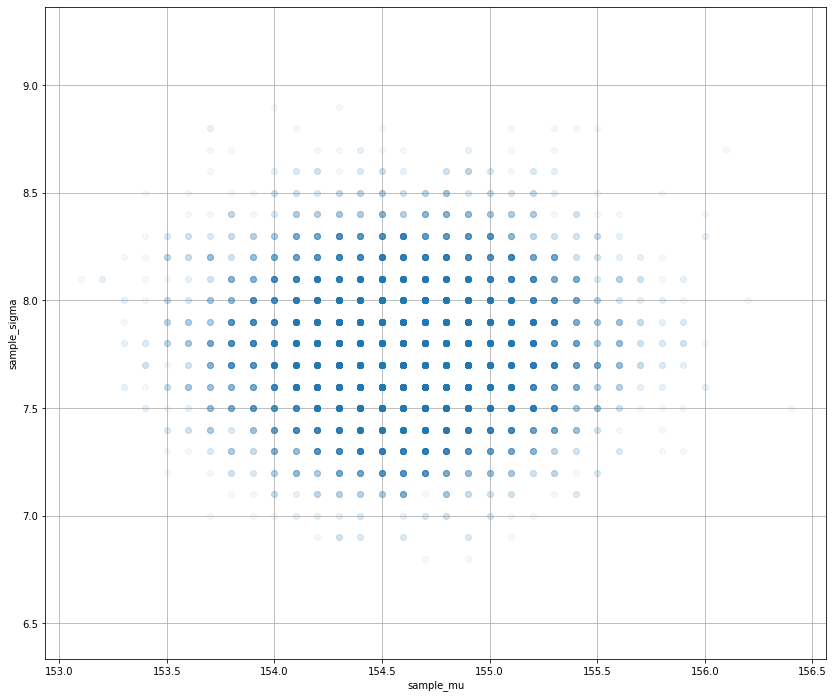

In [17]:
sample_rows = np.random.choice(np.arange(len(post)), size=10000, replace=True, 
                               p=(post_prob/post_prob.sum()))
sample_mu = post[:,0][sample_rows]
sample_sigma = post[:,1][sample_rows]

plt.figure(figsize=(14,12))
plt.plot(sample_mu, sample_sigma, 'o', alpha=0.05)
plt.axis('equal')
plt.grid(False)
plt.xlabel('sample_mu')
plt.ylabel('sample_sigma')
plt.grid()

Setelah memiliki distribusi posterior, ditarik sample dari distribusi tersebut. Hasil penarikan sample tersebut dicocokan dengan rerata yang menghasilkan `sample_mu` dan ada juga yang dicocokan dengan standar deviasi yang menghasilkan `sample_sigma`. Semakin mungkin suatu nilai kombinasi antara rerata dan standar deviasi maka frequensi muncul dari distribusi posterior juga semakin banyak. Pada plot ini ditandai dengan pekatnya warna dibandingkan dengan nilai nilai yang lain. Dari perhitungan diatas dapat dicari nilai rerata dan standar deviasi yang paling sering muncul.

In [18]:
member, count = np.unique(sample_rows, return_counts=True)
max_freq = np.where(count == np.max(count))
print("Maximum average from posterior sampling {} and maximum standard deveiation from posterior sampling {}"
      .format(sample_mu[member[max_freq]], sample_sigma[member[max_freq]]))

Maximum average from posterior sampling [155.2] and maximum standard deveiation from posterior sampling [8.2]


In [19]:
az.hdi(sample_mu), az.hdi(sample_sigma)

(array([153.8, 155.3]), array([7.3, 8.3]))

Setelah ini digunakan quadratic approximation untuk mencari nilai postrerior. Tahapanya sama, cuma untuk mencari distribusi posterior akan digunakan quadratic approximation. 

In [20]:
data_url = "https://raw.githubusercontent.com/pymc-devs/resources/master/Rethinking/Data/Howell1.csv"
df = pd.read_csv(data_url, sep=";")
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


         mean    sd  hdi_5.5%  hdi_94.5%
mu     154.61  0.42    153.95     155.25
sigma    7.77  0.29      7.30       8.22


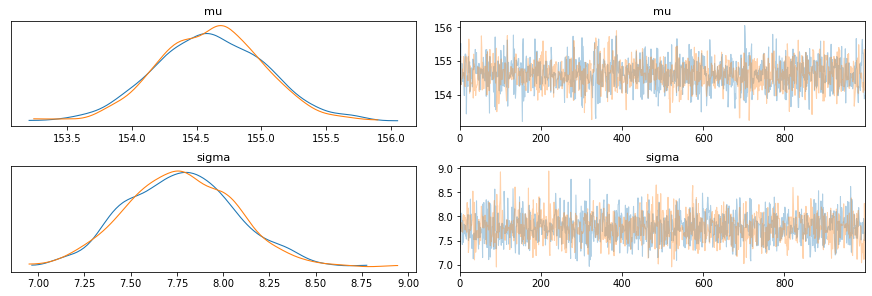

In [21]:
df2 = df[df['age'] >= 18]
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=df2.height)

with m4_1:
    trace_4_1 = pm.sample(1000, tune=1000)
    az.plot_trace(trace_4_1)
    print(az.summary(trace_4_1, hdi_prob=.89).round(2)[["mean", "sd", "hdi_5.5%", "hdi_94.5%"]])

Pada bagian pertama kode, dilakukan sampling menggunakan distribusi yang sama saat menggunakan grid approximation. Sama seperti sebelumnya, rerata dibentuk menggunakan distribusi normal dan standar deviasi menggunakan distribusi uniform. Keduanya memiliki parameter yang sama degan operasi grid approximation. 

Kode diatas menggunkan pola `with as:` untuk swabatas pemodelan. Semua model yang menggunakan pymc3 akan menggunakan pola yang sama untuk manajemen sumber daya komputasi. Hasil model yang dihasilkan tersimpan dalam variabel `m4_1`. Pada bagian kedua kode, variabel `m4_1` digunakan ulang untuk penarikan sampel dari distribusi posterior yang dihasilkan oleh bagian pertama. Hasil penarikan sample tersebut ditulis kesimpulanya menggunakan fungsi `az.summary(trace_4_1).round(2)`, dimana `trace_4_1` adalah hasil penarikan sample dari distribusi posterior?.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


         mean    sd  hdi_5.5%  hdi_94.5%
mu     177.86  0.10    177.71     178.04
sigma   24.57  0.94     23.02      25.96


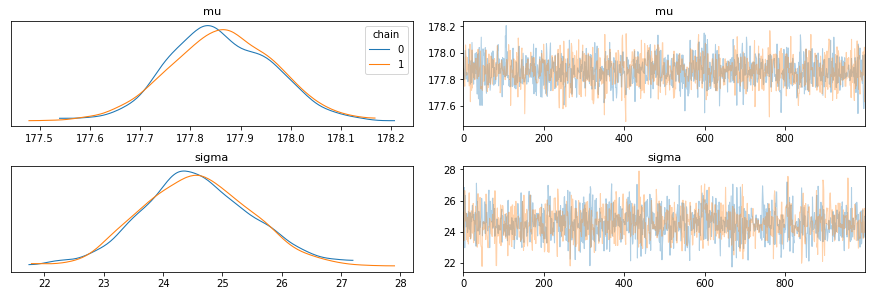

In [22]:
df2 = df[df['age'] >= 18]
with pm.Model() as m4_2:
    mu = pm.Normal('mu', mu=178, sd=.1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=df2.height)

with m4_2:
    trace_4_2 = pm.sample(1000, tune=1000)
    az.plot_trace(trace_4_2, legend=True)
    print(az.summary(trace_4_2, hdi_prob=.89).round(2)[["mean", "sd", "hdi_5.5%", "hdi_94.5%"]])

In [23]:
with m4_1:
    print("First Model")
    print(az.summary(trace_4_1, hdi_prob=.89).round(2)[["mean", "sd", "hdi_5.5%", "hdi_94.5%"]])
    print("\n")
with m4_2:
    print("Altered standard deviation in mean normal distribution  Model")
    print(az.summary(trace_4_2, hdi_prob=.89).round(2)[["mean", "sd", "hdi_5.5%", "hdi_94.5%"]])

First Model
         mean    sd  hdi_5.5%  hdi_94.5%
mu     154.61  0.42    153.95     155.25
sigma    7.77  0.29      7.30       8.22


Altered standard deviation in mean normal distribution  Model
         mean    sd  hdi_5.5%  hdi_94.5%
mu     177.86  0.10    177.71     178.04
sigma   24.57  0.94     23.02      25.96


Pada percobaan kedua, prior untuk rerata diganti standar deviasi distribusinya menjadi 0.1 dari 20. Yang patut diperhatikan disini adalah hasil dari penarikan samplenya. Dikarenakan distribusi rerata memiliki standar deviasi yang kecil, maka untuk model dapat mengandung seluruh informasi tinggi yang tersedia, dibuatlah standar deviasi yang besar. 

Ini dapat dilihat dari tabel summary. Pada model `m4_1` rerata mu posterior adalah 154.6 sedangkan untuk model `m4_2` 177.86 yang hanya berbeda sedikit dengan rerata prior $\mu$ yaitu 178. Standar deviasi pada model kedua memiliki nilai yang lebih besar dibandingkan model pertama karena alasan yang ditulis pada paragraf satu.

Selanjutnya akan dilakukan sampling dari hasil distirbusi posterior.

In [24]:
with m4_1:
    trace_df = pm.trace_to_dataframe(trace_4_1)
    print("Sampling Result Head\n", trace_df.head())
    print("Var-Cov Matrix\n", trace_df.cov())

Sampling Result Head
            mu     sigma
0  154.739106  7.978154
1  154.639847  7.937138
2  155.525277  7.942510
3  154.307612  7.691131
4  154.505775  8.067733
Var-Cov Matrix
              mu     sigma
mu     0.173238 -0.001574
sigma -0.001574  0.084879


Matriks yang terakhir mewakili relasi antara variabel posterior yang dicari. Pada diagonal matriks tersebut $\mu$  $[1,1]$ dan $\sigma$ $[2.2]$, tertulis variance untuk masing masing variable tersebut. Sedankan untuk non diagonal $[1,2]$ dan $[2,1]$ melambangkan covariance/relasi antar variabel. Nilau keduanya seharusnya sama karena relasinya berlaku dua arah. Hasil sampling yang dibuat pada 4.34 dapat dikerjakan dengan `pm.trace_to_dateframe`
> Tampaknya trace ini adalah nama lain dari sampling yang digunakan oleh library pymc3

Apabila ingin menarik sample sejumlah 10000 maka dapat dilakukan dengan

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 11 seconds.


         count        mean       std         min         25%         50%  \
mu     10000.0  154.607089  0.415682  152.549515  154.331559  154.609670   
sigma  10000.0    7.773201  0.298328    6.846322    7.566168    7.762759   

              75%         max  
mu     154.885057  156.241618  
sigma    7.969749    9.000168  


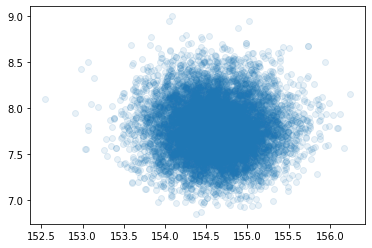

In [25]:
with m4_1:
    new_trace = pm.sample(5000)
    df_new_trace = pm.trace_to_dataframe(new_trace)
    print(df_new_trace.describe().T)
    plt.scatter(df_new_trace["mu"], df_new_trace["sigma"], alpha=0.1)

 Plot terakhir ini adalah hasil dari sampling yang mana $\mu$ ada pada x axis dan $\sigma$ ada pada y axis. Sama seperti pada halaman 88.

## Linear Prediction

Disini akan membahas relasi antar variabnel, lebih tepatnya adalah relasi antara tinggi dan berat badan.

In [26]:
data_url = "https://raw.githubusercontent.com/pymc-devs/resources/master/Rethinking/Data/Howell1.csv"
df = pd.read_csv(data_url, sep=";")
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


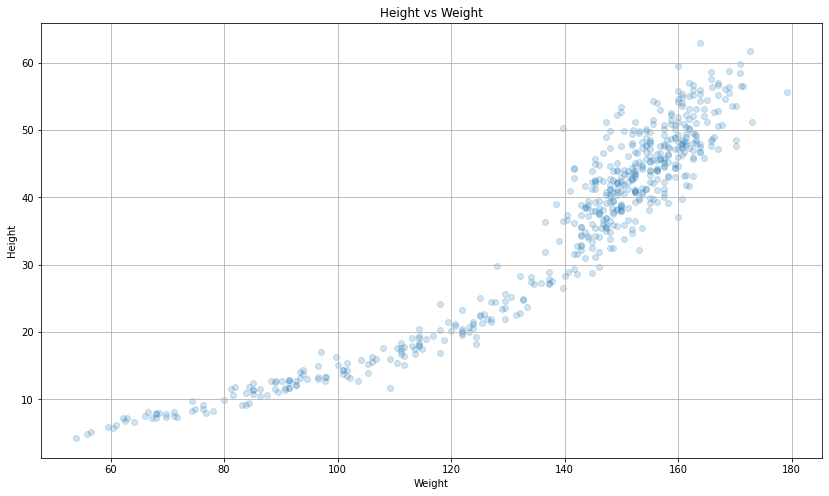

In [27]:
fig, ax = plt.subplots()
fig.set_figwidth(14)

fig.set_figheight(8)
ax.title.set_text("Height vs Weight")
ax.set_ylabel("Height")
ax.set_xlabel("Weight")
ax.scatter(df["height"], df["weight"], alpha=.2)

plt.grid()

Dapat dilihat ada korelasi antara berat sesesorang dengan tinggi seseorang. Semakin berat seseorang, maka akan ada kecendrungan orang ersebut juga tinggi. Akan dikuantifikasi korelasi tersebut dan selanjurnya akan dibuat model dengan dengan masukan tinggi dan keluaran berat.

Pendekaktan untuk melakukan hal yang dideskripsikan diatas dapat dikerjakan dengan strategi linear model. Pak Richard menjelaskan linear model sebagai membuat parameter rerata dari distribusi Gaussian sebagai fungsi linear dari variabel prediksi atau variabel-variabel yang dibuat tengah jalan. Pada kasus ini variabel prediksinya adalah tinggi badan dan yang dicoba diprediksi adalah rerata berat badan. 

Secara matematik, linear model bersumsi bahwa variable yang digunakan sebagai prediksi memiliki konstant tertentu dan memiliki relasi penambahan terhadap rerata variabel yang akan diprediksi. Pada model sebelumnya, saat hanya membuat posterior dari tinggi badan, model terdiri dari 

$$
\begin{align}
h_i &\sim \text{Normal}(\mu, \sigma) &[\text{Likelihood}]\\
\mu &\sim \text{Normal}(175, 20) &[\mu\; \text{prior}] \\
\sigma &\sim \text{Uniform}(0,50) &[\sigma\; \text{prior}]
\end{align}
$$


Sedangkan untuk linear model, akan ada beberapa tambahan


$$

\begin{align}
h_i &\sim \text{Normal}(\mu_i, \sigma) &[\text{Likelihood}]\\
\mu_i &= \alpha + \beta(x_i - \bar{x}) &[\text{Linear Model}]\\
\alpha &\sim \text{Normal}(175, 20) &[\alpha\; \text{prior}] \\
\beta &\sim \text{Normal}(0, 10) &[\beta\; \text{prior}] \\
\sigma &\sim \text{Uniform}(0,50) &[\sigma\; \text{prior}]
\end{align}

$$

Ada beberapa perbedaan dibandingkan model yang sudah dibuat sebelumnya. Pertama adalah adanya index pada nilai $\mu$ di likelihood. Index $i$ menandakan untuk masing-masing baris prediksi. Semisal untuk $h_i$ maka prediksi untuk baris tersebut yang dihasilkan oleh berat $x_i$

Selanjutnya pada bagian linear model, $\mu$ adalah hal yang akan dicari. Nilai $\alpha$ adalah sebuah distribusi dan begitu juga nilai $\beta$. Nilai $\beta$ dikalikan dengan variabel prediktor/terukur/termonitor yang dikurangi dengan rerata dari variabel tersebut. Dalam kasus diatas, variable prediktornya adalah berat badan dan $\bar{x}$ adalah rerata dari data berat.

Nilai $\alpha$ dan $\beta$ adalah asumsi untuk menjadikan linear model karena sebuah linear model membutuhkan intercept $\alpha$ dan gradien $\beta$. Untuk nilai $\sigma$ sama dengan model sebelumnya. Nilai $\alpha$, $\beta$ dan $\sigma$ ini adalah prior untuk model ini.

Sekarang dicoba sampling $\alpha$ dan $\beta$ dan dari hasil sampling tersebut akan diplot.

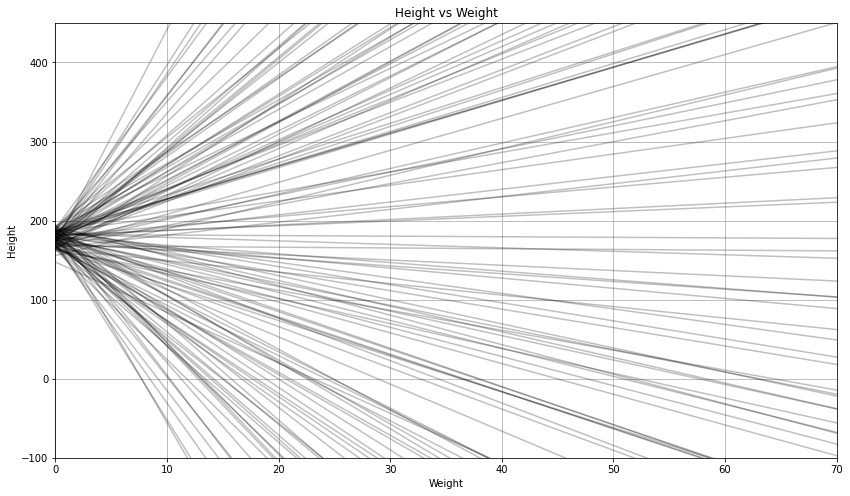

In [28]:
intercept_arr = np.random.normal(175,10, size=120)
gradient_arr = np.random.normal(0, 10, size=120)
zipped = np.array(list(zip(intercept_arr, gradient_arr)))

fig, ax = plt.subplots()
fig.set_figwidth(14)

fig.set_figheight(8)
ax.title.set_text("Height vs Weight")
ax.set_ylabel("Height")
ax.set_xlabel("Weight")
ax.set_xlim([0, 70])
ax.set_ylim([-100, 450])
for intercept, gradient in zipped:
    ax.plot(range(0, 77), [(intercept + gradient*i) for i in range(0, 77)], color='black', alpha=.25)
plt.grid()

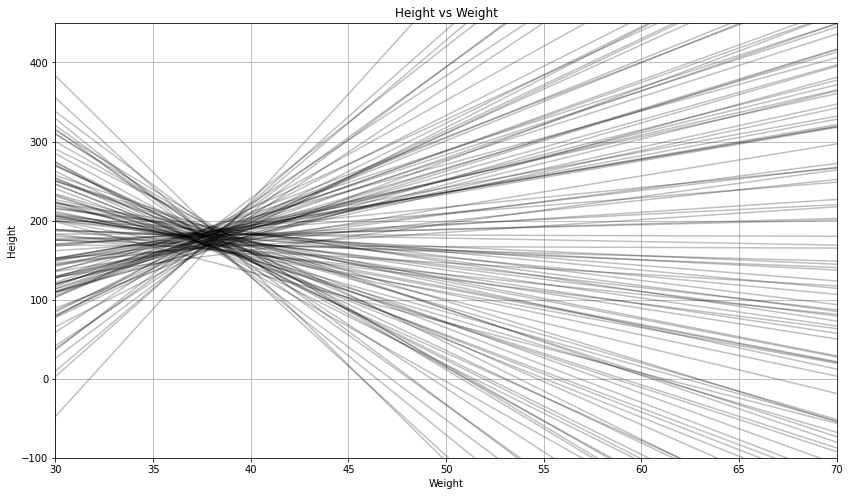

In [29]:
fig, ax = plt.subplots()
fig.set_figwidth(14)

fig.set_figheight(8)
ax.title.set_text("Height vs Weight")
ax.set_ylabel("Height")
ax.set_xlabel("Weight")
ax.set_xlim([30, 70])
ax.set_ylim([-100, 450])
weight_list = range(0, 77)
weight_avg = np.average(weight_list)
for intercept, gradient in zipped:
    ax.plot(weight_list, [(intercept + gradient*(i - weight_avg)) for i in weight_list], color='black', alpha=.25)
plt.grid()

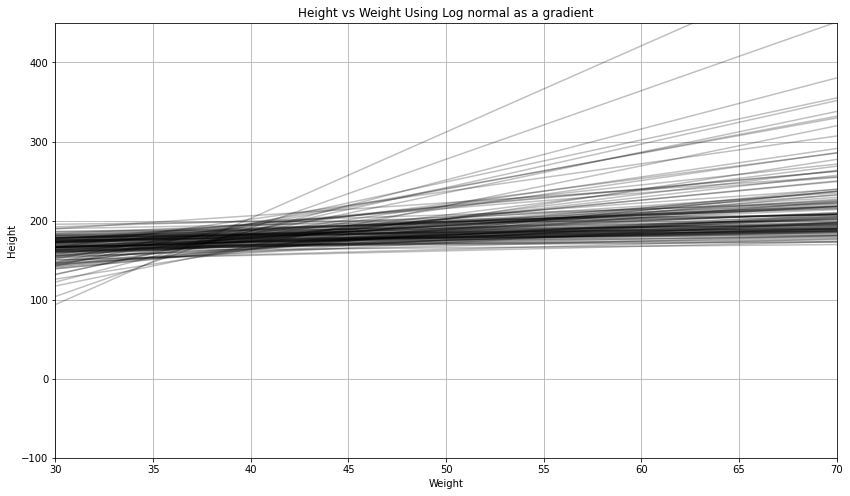

In [30]:
intercept_arr = np.random.normal(175,10, size=120)
gradient_arr = np.random.lognormal(0, 1, size=120)
zipped = np.array(list(zip(intercept_arr, gradient_arr)))

fig, ax = plt.subplots()
fig.set_figwidth(14)

fig.set_figheight(8)
ax.title.set_text("Height vs Weight Using Log normal as a gradient")
ax.set_ylabel("Height")
ax.set_xlabel("Weight")
ax.set_xlim([30, 70])
ax.set_ylim([-100, 450])
weight_list = range(0, 77)
weight_avg = np.average(weight_list)
for intercept, gradient in zipped:
    ax.plot(weight_list, [(intercept + gradient*(i - weight_avg)) for i in weight_list], color='black', alpha=.25)
plt.grid()

Pada contoh plot diatas dicoba diambil intercept $\alpha$ dan gradient $\beta$ dari distribusi yang sudah ditentukan. Pada plot pertama persamaan linear tidak menggunakan $(x_i - \bar{x})$. Ini mengakibatkan pusat dari distribusi ada pada berat 0. Apabila ingin meenggeset pusat distribusi tersebut mejadi ketengan sesuai dengan contoh yang ada pada buk u butuh penerapan rerata dari sample berat yang diberikan. Setelah hal tersebut diterapkan, plot akan menghasilkan ploy yang kedua.

Pada kedua plot pertama dapat dilihat banyak plot yang tidak mungkin seperti tinggi yang bernilai negatif dan tinggi lebih besar dari 300 centimeter. Ini menandakan prior yang dipilih tidak cukup baik. Untuk mencegah munculnya tinggi bernilai negatif dan gradient tinggi yang terlalu curam, dapati digunakan distribusi log normal untuk gradient.

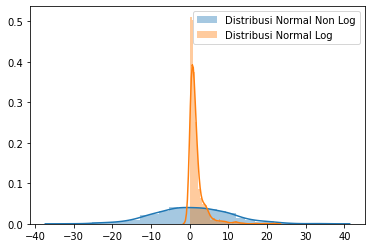

In [31]:
asd = np.random.normal(0, 10, size=1000)
sns.distplot(asd, label='Distribusi Normal Non Log')

asd2 = np.random.lognormal(0,1, size=1000)
sns.distplot(asd2, label='Distribusi Normal Log')
plt.legend()

Bisa dilihat pada plot diatas, distribusi untuk memiliki standar deviasi yang rendah apabila dibandingkan dengan distribusi normal biasa. Distribusi normal log juga tidak memliliki nilai negatif. Ini baik untuk prror karena secara intuitif, relasi antara berat dan tinggi tidak mungkin berbanding terbalik. Oleh karena itu, beta prior akan digantikan dengan log normal, sehingga model akan menjadi 

$$
\begin{align}
h_i &\sim \text{Normal}(\mu_i, \sigma) &[\text{Likelihood}]\\
\mu_i &= \alpha + \beta(x_i - \bar{x}) &[\text{Linear Model}]\\
\alpha &\sim \text{Normal}(175, 20) &[\alpha\; \text{prior}] \\
\beta &\sim \text{Log-Normal}(0, 1) &[\beta\; \text{prior}] \\
\sigma &\sim \text{Uniform}(0,50) &[\sigma\; \text{prior}]
\end{align}
$$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


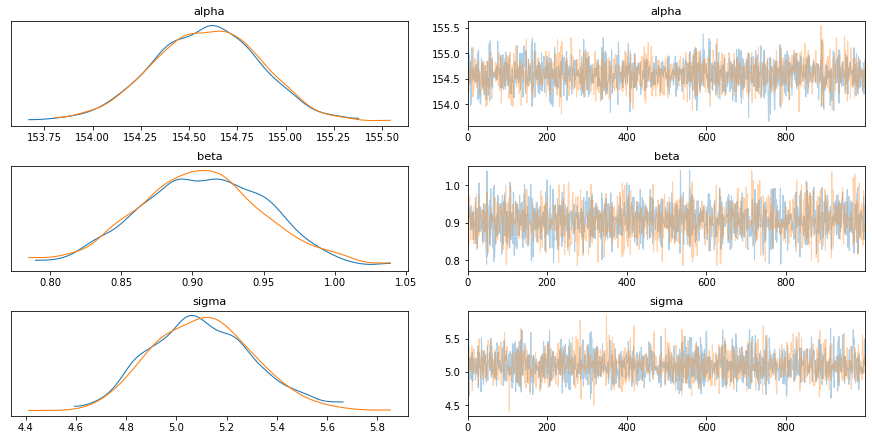

In [32]:
df2 = df2.assign(weight_c=pd.Series(df2.weight - df2.weight.mean()))
with pm.Model() as m4_3:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta * df2.weight_c
    height = pm.Normal('height', mu=mu, sd=sigma, observed=df2.height)

with m4_3:
    trace_4_3 = pm.sample(1000, tune=1000)
    az.plot_trace(trace_4_3);

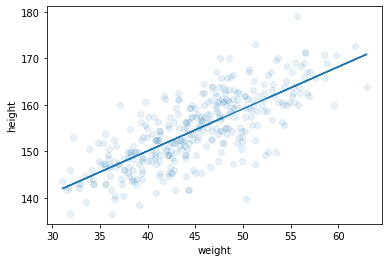

In [33]:
plt.scatter(df2.weight, df2.height, alpha=.1)
plt.plot(df2.weight, trace_4_3['alpha'].mean() + trace_4_3['beta'].mean() * df2.weight_c)
plt.xlabel(df2.columns[1])
plt.ylabel(df2.columns[0]);

Pada bagian pertama, dibuat model menggunakan library pymc3 dengan deskripsi yang sudah dijabarkan. Posterior yang dikeluarkan dari model adalah posterior tinggi. Meski demikian, model tidak hanyab memiliki variabel tinggi. Variabel $\alpha$ dan $\beta$ juga dapat ditarik dari model. Pada bagian plot terakhir, hasil dari penarikan sample untuk $\alpha$ dan $\beta$ direratakan untuk mendapat satu nilai yang akan digunakan sebagai konstanta dalam fungsi linear, Hasil dari fungsi linear tersebut dan data antara berat dan tinggi diplotkan.

`df2.weight_c` memiliki nilai yang sama dengan $x_i-\bar{x}$. Ini adalah dasar regresi linear menggunakan bayesian. Selanjutnya akan dibandingkan jumlah data dan hasil regresi. Sample yang digunakan adalah 10, 50, 150, dan semuanya. Seharusnya semakin banyak yang tersedia akan semakin membuat nilai $\alpha$ dan $\beta$ memiliki standar deviasi yang semakin kecil.

In [34]:
df_trance = pm.trace_to_dataframe(trace_4_3)

In [35]:
df_trance.cov()

,alpha,beta,sigma
alpha,0.074674,-0.000200,-0.000515
beta,-0.000200,0.001967,-0.000181
sigma,-0.000515,-0.000181,0.040761


In [36]:
def limited_data_regression(dataframe, n_data):
    new_df = dataframe[:n_data]
    with pm.Model() as pm_4:
        alpha = pm.Normal('alpha', mu=178, sd=100)
        beta = pm.Normal('beta', mu=0, sd=10)
        sigma = pm.Uniform('sigma', lower=0, upper=50)
        mu = alpha + beta * new_df.weight_c
        height = pm.Normal('height', mu=mu, sd=sigma, observed=new_df.height)
    with pm_4:
        model_trace = pm.sample(1000, tune=1000)
        trace_df = pm.trace_to_dataframe(model_trace)
    
    trace_size = len(trace_df['alpha'])
    arr_result = []
    for i in range(20):
        arr_index = np.random.choice(range(trace_size))
        arr_result.append({
            "alpha": trace_df["alpha"][arr_index],
            "beta": trace_df["beta"][arr_index]
        })
    return arr_result, new_df

WORK IN 10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


WORK IN 50


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


WORK IN 150


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


WORK IN 352


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


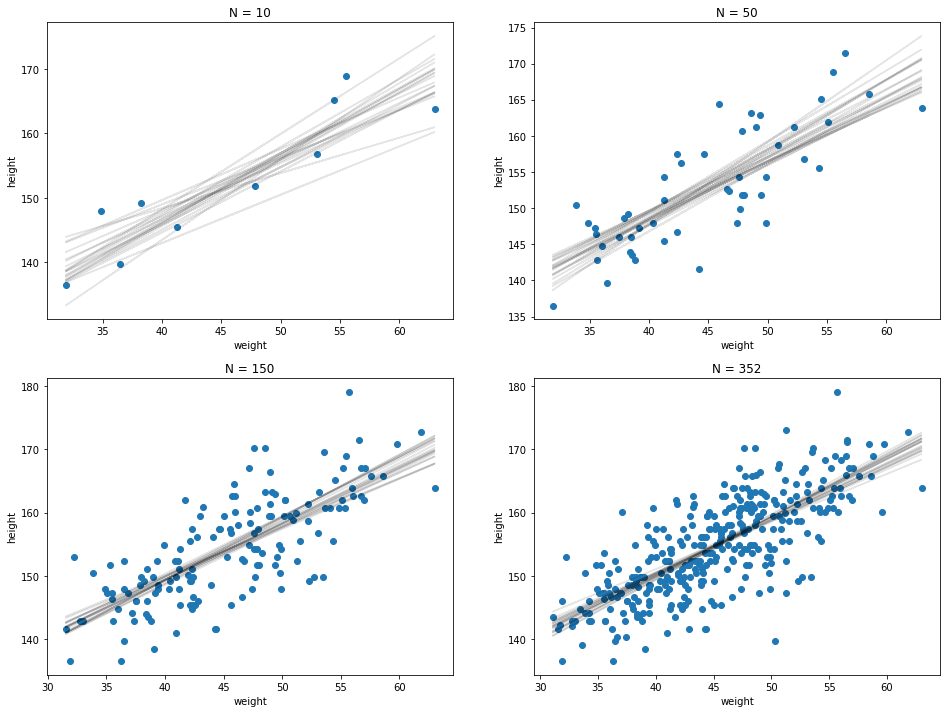

In [37]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2)
fig.set_figwidth(16)
fig.set_figheight(12)

ax = [ax1, ax2, ax3, ax4]
n_sample = [10, 50, 150, 352]
for index in range(4):
    print("WORK IN {}".format(n_sample[index]))
    arr_result, new_df = limited_data_regression(df2, n_sample[index])
    ax[index].scatter(new_df.weight, new_df.height)
    for i in arr_result:
        ax[index].plot(new_df.weight, i['alpha'] + i['beta'] * new_df.weight_c, color='black', alpha=.1)
    ax[index].set_title('N = {}'.format(n_sample[index]))
    ax[index].set_xlabel('weight')
    ax[index].set_ylabel('height')

Percobaan menggunakan jumlah sample yang berbeda menghasilkan plot seperti diatas. Dapat dilihat semakin besar nilai $N$ yaitu jumlah data yang tersedia berbanding lurus dengan kekonvergenan regresi yang dibangun. Ini secara langsung mengindikasikan bahwa model memiliki ketidaktentuan yang menjadi properti sebuah model. Semisal menggunakan model terakhir (menggunakan semua data yang tersedia) bagaimana distribusi tinggi orang yang memiliki berat 60 kg. Ini dapat dicari dengan

In [38]:
with pm.Model() as pm_4:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta * df2.weight_c)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=df2.height)
with pm_4:
    model_trace = pm.sample(1000, tune=1000)
    trace_df = pm.trace_to_dataframe(model_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


Text(0.5, 0, 'height|weight=50')

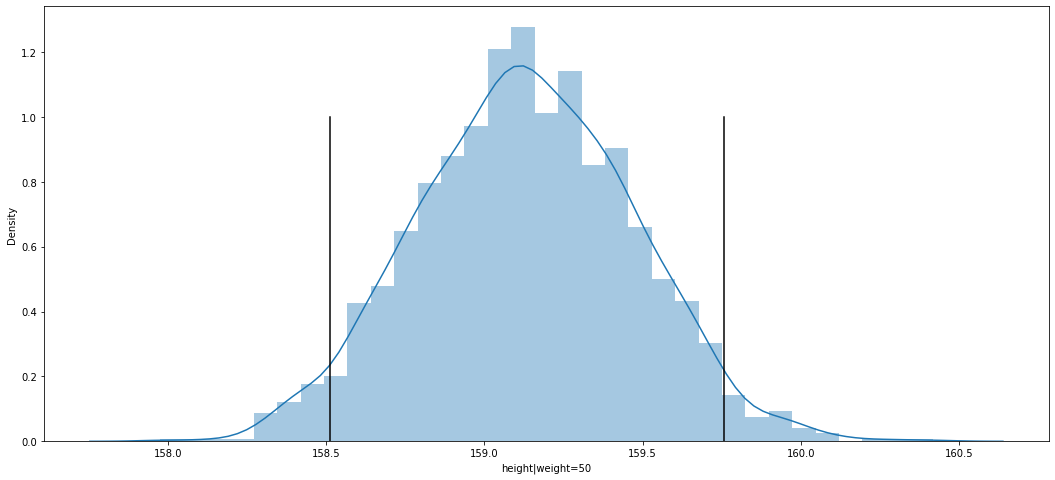

In [39]:
height_mu = trace_df['alpha'] + trace_df['beta'] * (50 - df2.weight.mean())
[low_limit, high_limit] = az.hdi(np.array(height_mu), hdi=.89)

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figwidth(18)
fig.set_figheight(8)

ax = sns.distplot(height_mu)
ax.plot([low_limit, low_limit], [0, 1], color='black')
ax.plot([high_limit, high_limit], [0, 1], color='black')

ax.set_ylabel("Density")
ax.set_xlabel("height|weight=50")

Seperti yang dapat dilihat pada distribusi ini, adanya ketidaktentuan dalam penentuan tinggi apabila diketahu berat seseorang. Pada plot diatas disajikan ada dua buah garis yang menandakan HPDI (highest posterior density interval) dengan rentang sebesar $.89$. Plot ini dapat dikerjakan untuk masing masing nilai dalam berat sehingga diketahui HPDI dari regresi.


(130.0, 180.0)

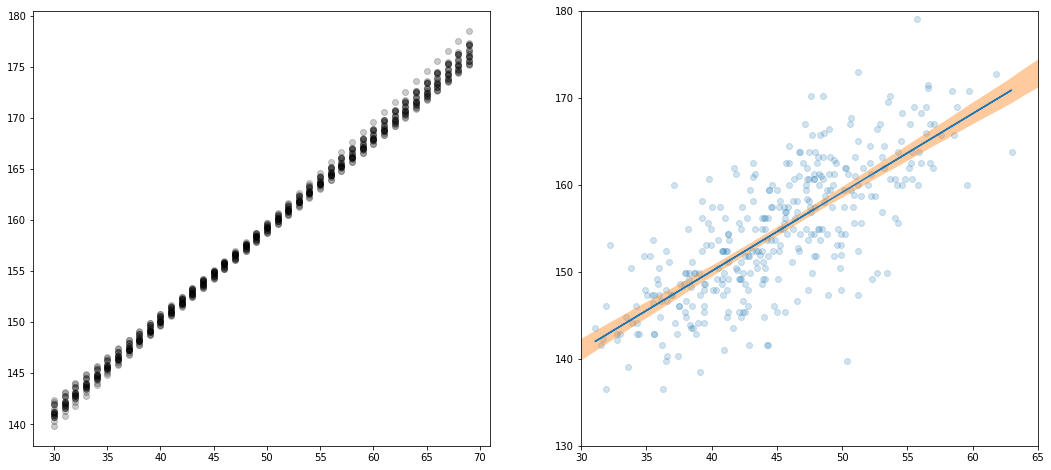

In [40]:
def get_height_estimation(n_size, weight):
    result = trace_df['alpha'] + trace_df['beta'] * (weight - df2.weight.mean())
    return result[:n_size]

def get_hdi_in_point(weight):
    result = trace_df['alpha'] + trace_df['beta'] * (weight - df2.weight.mean())
    [low_limit, high_limit] = az.hdi(np.array(result), hdi=.89)
    return low_limit, high_limit

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(18)
fig.set_figheight(8)
upper_border = []
lower_border = []

for i in range(30, 70):
    height_estimate = get_height_estimation(20, i)
    ax1.scatter(np.ones(len(height_estimate)) * i, height_estimate, color='black', alpha=.2)
    low_limit, high_limit = get_hdi_in_point(i)
    upper_border.append(high_limit)
    lower_border.append(low_limit)

ax2.scatter(df2.weight, df2.height, alpha=.2)
ax2.plot(df2.weight, trace_df['alpha'].mean() + trace_df['beta'].mean() * df2.weight_c)
ax2.fill_between(range(30, 70), lower_border, upper_border, alpha=.4)
ax2.set_xlim([30, 65])
ax2.set_ylim([130, 180])

Pada plot pertama, ditarik 20 angka dari hasil linear regresi. Ini tidak menghasilkan angka yang sama karena masing-masing variabel pada regersi linear adalah sebuah distiribusi. Masing-masing angka tersebut kemudian diplot. Dapat dilihat semakin mendekati rerata, maka plot semakin intens (intens ini hasil dari tumpukan titik yang diberi transparansi).

Pada plot kedua, diperlihatkan data, regresi menggunakan rerata distribusi dan interval kepercayaan 0.89. Bagian interval memiliki bentuk yang mirip dengan plot pertama. Mereka berdua menyempit pada nilai 50 dan kembali melebar saat data pada berat tersebut kurang tersedia. 

Pada plot kedua, sudah diberikan interval kepercayaan? 0.89 untuk regresi akan tetapi ini hanya baru memasukan nilai $\mu_i$ dan sedangkan nilai tinggi yang sebenarnya adalah $h_i \sim \text{Normal}(\mu_i, \sigma)$. Untuk mendapatkan nilai tinggi yang sebenarnya, diharuskan menggunakan distribusi posterior. 

In [41]:
def get_actual_hdi(weight, sample_size=None):
    result = trace_df['alpha'] + trace_df['beta'] * (weight - df2.weight.mean())
    if sample_size is None:
        size = len(result)
    else:
        size = sample_size
    likelihood = stats.norm.rvs(loc=result, scale=trace_df['sigma'], size=sample_size)
    [low_limit, high_limit] = az.hdi(np.array(likelihood), hdi=.89)
    return low_limit, high_limit

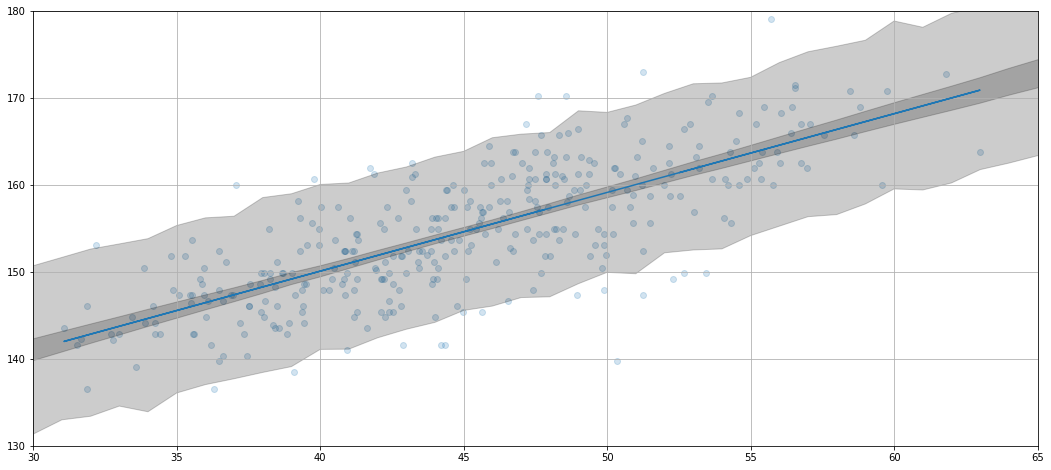

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figwidth(18)
fig.set_figheight(8)
upper_border = []
lower_border = []

upper_border_actual = []
lower_border_actual = []

for i in range(30, 70):
    low_limit, high_limit = get_hdi_in_point(i)
    low_limit_actual, high_limit_actual = get_actual_hdi(i, 2000)
    
    upper_border.append(high_limit)
    lower_border.append(low_limit)
    
    upper_border_actual.append(high_limit_actual)
    lower_border_actual.append(low_limit_actual)

ax.scatter(df2.weight, df2.height, alpha=.2)
ax.plot(df2.weight, trace_df['alpha'].mean() + trace_df['beta'].mean() * df2.weight_c)
ax.fill_between(range(30, 70), lower_border, upper_border, alpha=.2, color='black')
ax.fill_between(range(30, 70), lower_border_actual, upper_border_actual, alpha=.2, color='black')
ax.set_xlim([30, 65])
ax.set_ylim([130, 180])

plt.grid()

Pada plot ini ditambahkan area ketidaktentuan tinggi yang sebenernya. Bayang yang besar menandakan bahwa untuk suatu berat semisal 50, orang yang diperiksa tingginya --sebanyak 89 persen -- ada pada rentang 150 sampai 168. Mengapa diambil nilai 89 ini karena referensi dari buku demikian. Ini dapat diganti pada keyword `hdi` pada masing masing fungsi interval. Apabila garis interval terlalu kasar, menambahkan sample pada pnearikan distribusi posterior akan membuatnya relatif lebih halus. 

Setelah ini akan disajikan regresi menggunakan polinomial dan Splines. Untuk pemodelan polinomial, model dapat ditulis sebagai

$$
\begin{align}
h_i &\sim \text{Normal}(\mu_i, \sigma) &[\text{Likelihood}]\\
\mu_i &= \alpha + \beta_1 x_i + \beta_2 x_i^2 &[\text{Linear Model}]\\
\alpha &\sim \text{Normal}(175, 20) &[\alpha\; \text{prior}] \\
\beta_1 &\sim \text{Log-Normal}(0, 1) &[\beta_1\; \text{prior}] \\
\beta_2 &\sim \text{Normal}(0, 1) &[\beta_2\; \text{prior}] \\
\sigma &\sim \text{Uniform}(0,50) &[\sigma\; \text{prior}]
\end{align}
$$

In [43]:
with pm.Model() as pm_5:
    alpha = pm.Normal('alpha', mu=175, sd=20)
    beta_1 = pm.Lognormal('beta_1', mu=0, sd=1)
    beta_2 = pm.Normal('beta_2', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta_1 * df2.weight + beta_2 * (df2.weight ** 2))
    height = pm.Normal('height', mu=mu, sd=sigma, observed=df2.height)
with pm_5:
    model_trace = pm.sample(1000, tune=1000)
    trace_df = pm.trace_to_dataframe(model_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta_2, beta_1, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 39 seconds.
There were 118 divergences after tuning. Increase `target_accept` or reparameterize.
There were 166 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


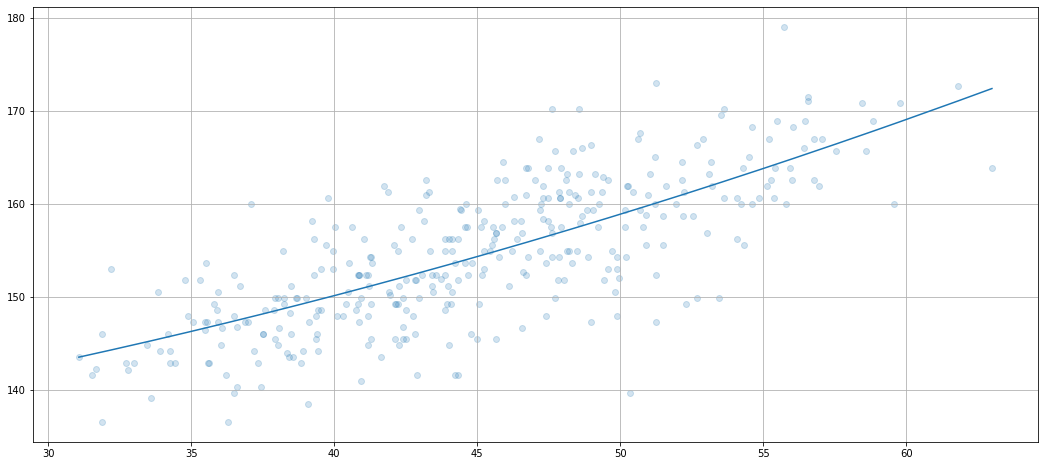

In [44]:
def quadratic_weight(weight):
    return trace_df['alpha'].mean() \
    + trace_df['beta_1'].mean() * weight \
    + trace_df['beta_2'].mean() * weight ** 2

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figwidth(18)
fig.set_figheight(8)
ax.scatter(df2.weight, df2.height, alpha=.2)
ax.plot(np.sort(df2.weight), [quadratic_weight(i) for i in np.sort(df2.weight)]) 

plt.grid()

dalam plot diatas, garis regresi terlihat agak bengkok apabila dibandigkan dengan model sebelumnya. Ini adalah hasil dari model quadratic.

Practice Problem

4E1. The first line, because it constructed from next distribution and $y$ usually have data that model need to fit

4E2. There are two, the $\mu$ that represent average of normal distribution and $\sigma$ that represent standard deviation of normal distribution

4E3. 
$$x_1 \text{Normal}(\mu, \sigma| h)= \frac{\text{Normal}(h | \mu, \sigma) \times \text{Normal}(0, 10) \times \text{Exponential}(1)}{\int \int \text{Normal}(h | \mu, \sigma) \times \text{Normal}(0, 10) \times \text{Exponential}(1) d\mu d\sigma}
    $$
4E4. Linear model adalah bagian persamaanya   
4E5. Distribusi posterior akan memiliki 3 parameter yaitu $\alpha$ $\beta$ dan $\sigma$. Nilai mu tidak dianggap karena dapat dibangun dari nilai $\alpha$ dan $\beta$. Nilau $\mu$ apabila ingin disimpan dalam model pymc3 dapat dilakukan dengan menggunakan fungsi `pm.Deterministic`

4M1


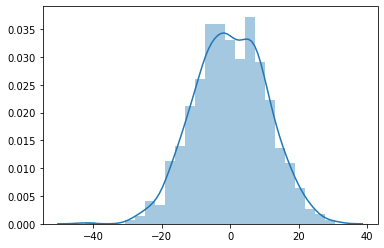

In [45]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=0, scale=10, size=n_samples)
sample_sigma = stats.expon.rvs(size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)

sns.distplot(prior_h)

4M2 Dunno, not use quap

4M4 Model untuk menetukan tinggi badan setiap murid yang datanya diambil per tahun selama tiga tahun. Berapa tinggi para murid pada tahun ke empat. Model standar yang dikenalkan oleh Pak Richard adalah seperti

$$
\begin{align}
h_i &\sim \text{Normal}(\mu_i, \sigma) &[\text{Likelihood}]\\
\mu_i &= \alpha + \beta(x_i - \bar{x}) &[\text{Linear Model}]\\
\alpha &\sim \text{Normal}(175, 20) &[\alpha\; \text{prior}] \\
\beta &\sim \text{Normal}(0, 10) &[\beta\; \text{prior}] \\
\sigma &\sim \text{Uniform}(0,50) &[\sigma\; \text{prior}]
\end{align}
$$

Yang menjadi perbedaan antara linear model yang diperkenalkan pada materi dan yang ditabnyakan pada soal adalah dimensi data. Pada kasus yang pertama, ada dua dimensi, yaitu berat sebagai parameter yang diobservasi dan tinggi sebagai parameter yang dicari berdasarkan parameter observasi. Sedangkan pada kasus kedua, parameter terobservasi diganti dengan data serial wakyu yang menjabarkan tinggi. Disini dilakukan asumsi bahwa tahun pertama, tahun kedua, dan tahun ketiga berpengaruh secara linear terhadap tinggi pada tahun keempat. Sehingga pemodelan diatas dapat djabarkan ulang sebagai

$$
\begin{align}
h_i &\sim \text{Normal}(\mu_i, \sigma) &[\text{Likelihood}]\\
\mu_i &= \alpha + \beta_1(x_{1i} - \bar{x_1}) + \beta_2(x_{2i} - \bar{x_2}) + \beta_3(x_{3i} - \bar{x_3}) &[\text{Linear Model}]\\
\alpha &\sim \text{Normal}(175, 20) &[\alpha\; \text{prior}] \\
\beta_1 &\sim \text{Normal}(0, 10) &[\beta_1\; \text{prior}] \\
\beta_2 &\sim \text{Normal}(0, 10) &[\beta_2\; \text{prior}] \\
\beta_3 &\sim \text{Normal}(0, 10) &[\beta_3\; \text{prior}] \\
\sigma &\sim \text{Uniform}(0,50) &[\sigma\; \text{prior}]
\end{align}
$$

Pada penjelasan diatas $\bar{x_n}$ adalah rerata tinggi untuk tahun ke $n$. DIkarenakan ada tiga tahun observase maka $n={1,2,3}$. Tapi model ini memiliki masalah karena peneliti tidak memiliki data tinggi pada tahun keempat sehingga model ini tidak dapat dicocokan dengan data observasi. Untuk mengakali ini maka model harus diubah. 

Model yang diajukan selanjutnya adalah model yang memberikan data tinggi untuk tahun sekarang dan mengeluarkan data tinggi untuk tahun selanjutnya. Ini mungkin dapat dikerjakan karena adaya data tinggi selama tiga tahun. Pemodelan dapat menggabungkan data tahun pertama dan tahun kedua dan mencocokan dengan data tahun kedua dan tahun ketinga. Model ini dapat ditulis sebagai

$$
\begin{align}
h_i &\sim \text{Normal}(\mu_i, \sigma) &[\text{Likelihood}]\\
\mu_i &= \alpha + \beta(x_i - \bar{x}) &[\text{Linear Model}]\\
\alpha &\sim \text{Normal}(\bar{x}, 20) &[\alpha\; \text{prior}] \\
\beta &\sim \text{Log-Normal}(0, 10) &[\beta\; \text{prior}] \\
\sigma &\sim \text{Uniform}(0,50) &[\sigma\; \text{prior}]
\end{align}
$$

Pada pemodelan kedua $\beta$ dipilih menggunakan Log normal karena gradient tinggi tidak mungkin negatif. Pada variable $\alpha$ dipilih distribusi normal dengan rerata sama dengan rerata gabungan data tinggi tahun pertama dan tahun kedua. Untuk standar deviasi mungkin paling standar. Sisanya sama dengan variabel yang ada pada kasus awal bab ini. Model ini berasumsi bahwa perubahan tinggi setiap tahun adalah linear. Maksud dari linear disini adalah setiap tahu berubah dengan suatu distribusi. Tentunya ini salah karena manusia berhenti meninggi pada umut 20 an. Ini tetap dapat dipakai (sama sebagaimana geocentric model) karena subjek yang diteliti adalah remaja (student) yang masih mengalami pertumbuhan.

4M5 Ini akan menjadi masalah pada intercept $\alpha$. Semisal data tinggi yang diketahui sebelumnya untuk umur 14 dan 16. Tentunya rerata $\bar{x}$ akan beberbeda apabila data tinggi untuk umut 17 dan 20. Jadi nilai alpha haruslah dinamis dan dapat mencakup segala umur remaja. Ini dapat dikerjakan dengan menaikan nilai standar deviasi pada variabel $\alpha$ sehingga intercept-intercept yang sebelumnya kurang mungkin terjadi smenjadi semakin dapat terjadi.

4M6 Apabila diketahi variance tinggi dalam satu umur, maka ini dapat mengubah prior $\sigma$ sehingga distribusi prediksi $h_i$ sesuai dengan data variabce yang sudah ada

4H1 Digunakan data yang sama seperti pada bab. Prediksi dapat dilakukan dengan membangun model



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


           alpha      beta     sigma
0     154.651479  0.811699  5.142642
1     154.249725  0.960083  4.945222
2     154.315922  0.940921  5.050718
3     154.791912  0.970667  5.263026
4     154.348832  0.915342  5.024426
...          ...       ...       ...
1995  154.878891  0.931535  4.915422
1996  154.228999  0.896181  5.411830
1997  154.709431  0.895693  5.123253
1998  154.335434  0.899715  5.125598
1999  154.193179  0.892098  5.072400

[2000 rows x 3 columns]


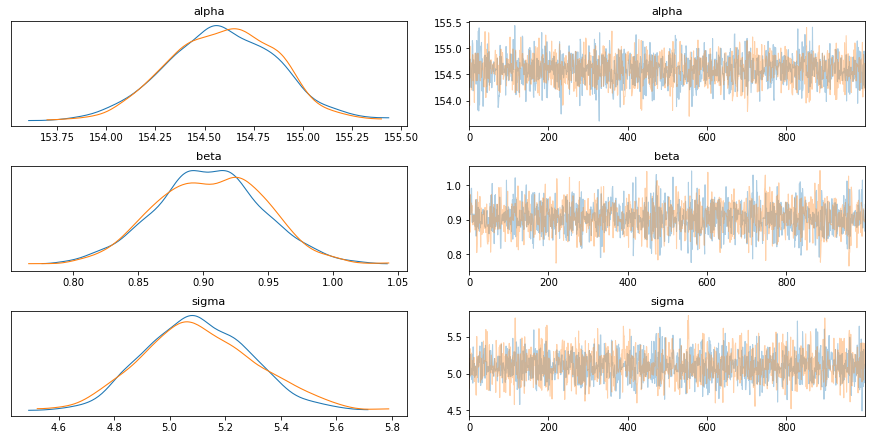

In [46]:
df2 = df2.assign(weight_c=pd.Series(df2.weight - df2.weight.mean()))
with pm.Model() as m4_3:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta * df2.weight_c
    height = pm.Normal('height', mu=mu, sd=sigma, observed=df2.height)

with m4_3:
    trace_4_3 = pm.sample(1000, tune=1000)
    az.plot_trace(trace_4_3);
    trace_df = pm.trace_to_dataframe(trace_4_3)

print(trace_df)

In [47]:
def get_actual_hdi(weight, sample_size=None):
    result = trace_df['alpha'] + trace_df['beta'] * (weight - df2.weight.mean())
    if sample_size is None:
        size = len(result)
    else:
        size = sample_size
    likelihood = stats.norm.rvs(loc=result, scale=trace_df['sigma'], size=sample_size)
    [low_limit, high_limit] = az.hdi(np.array(likelihood), hdi=.89)
    return low_limit, high_limit

In [51]:
for i in [46.95, 43.72, 64.78, 32.59, 54.63]:
    expected_height = trace_df['alpha'].mean() + trace_df['beta'].mean() * (i - df2.weight.mean())
    low, high = get_actual_hdi(i)
    print ("Expected Height for {:.2f} is {:.2f} cml low is {:.2f} and high is {:.2f} for HDI 0.89".format(i, expected_height, low, high))

Expected Height for 46.95 is 156.36 cml low is 147.58 and high is 166.10 for HDI 0.89
Expected Height for 43.72 is 153.44 cml low is 143.76 and high is 162.49 for HDI 0.89
Expected Height for 64.78 is 172.51 cml low is 162.80 and high is 181.74 for HDI 0.89
Expected Height for 32.59 is 143.36 cml low is 134.02 and high is 153.55 for HDI 0.89
Expected Height for 54.63 is 163.32 cml low is 154.51 and high is 173.22 for HDI 0.89


In [56]:
df2 = df[df['age'] < 18]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


           alpha      beta     sigma
0     108.000827  2.695480  8.632482
1     108.237532  2.687504  9.183578
2     108.373583  2.728623  8.430803
3     108.373583  2.728623  8.430803
4     107.367559  2.830507  7.959306
...          ...       ...       ...
1995  107.590666  2.673949  8.241556
1996  108.547140  2.722617  8.190328
1997  108.321218  2.748762  8.714948
1998  107.918193  2.662954  8.507131
1999  109.011595  2.710280  8.249439

[2000 rows x 3 columns]


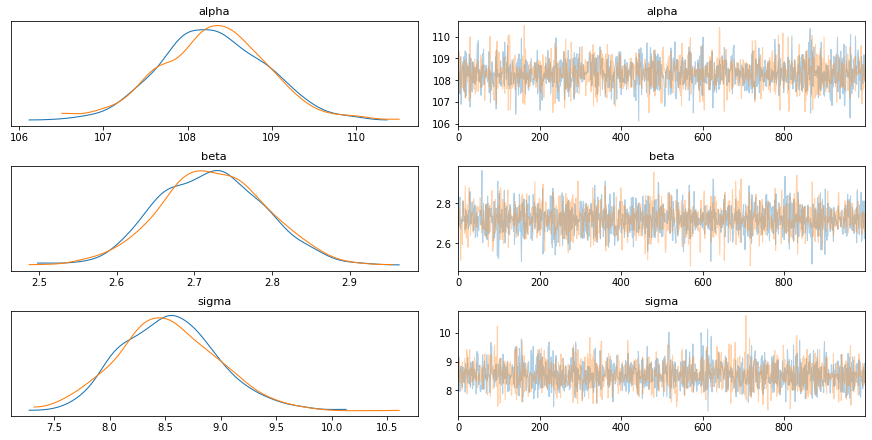

In [58]:
df2 = df2.assign(weight_c=pd.Series(df2.weight - df2.weight.mean()))
with pm.Model() as m4_3:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta * df2.weight_c
    height = pm.Normal('height', mu=mu, sd=sigma, observed=df2.height)

with m4_3:
    trace_4_3 = pm.sample(1000, tune=1000)
    az.plot_trace(trace_4_3);
    trace_df = pm.trace_to_dataframe(trace_4_3)

print(trace_df)

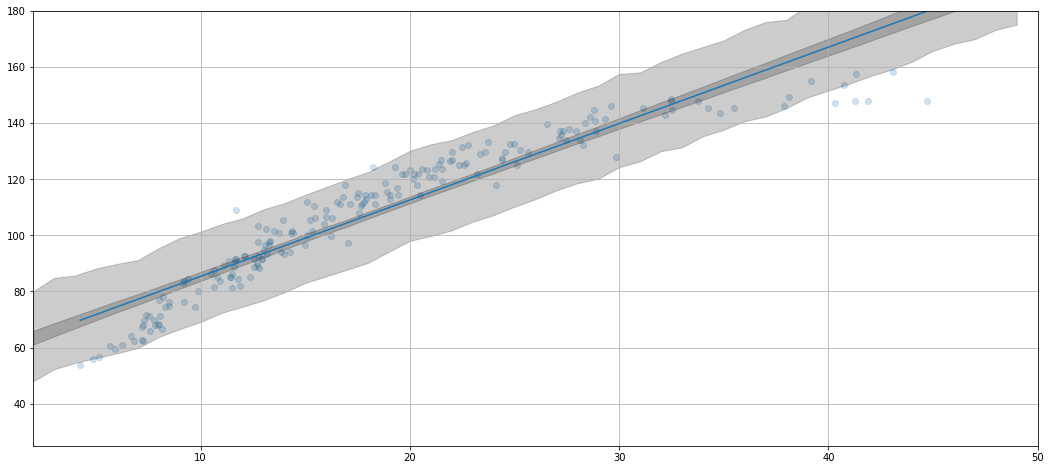

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figwidth(18)
fig.set_figheight(8)
upper_border = []
lower_border = []

upper_border_actual = []
lower_border_actual = []
weight_range = range(2,50)
for i in weight_range:
    low_limit, high_limit = get_hdi_in_point(i)
    low_limit_actual, high_limit_actual = get_actual_hdi(i, 2000)
    
    upper_border.append(high_limit)
    lower_border.append(low_limit)
    
    upper_border_actual.append(high_limit_actual)
    lower_border_actual.append(low_limit_actual)

ax.scatter(df2.weight, df2.height, alpha=.2)
ax.plot(np.sort(df2.weight), trace_df['alpha'].mean() + trace_df['beta'].mean() * np.sort(df2.weight_c))
ax.fill_between(weight_range, lower_border, upper_border, alpha=.2, color='black')
ax.fill_between(weight_range, lower_border_actual, upper_border_actual, alpha=.2, color='black')

ax.set_xlim([2,50])
ax.set_ylim([25, 180])

plt.grid()

4H2 (a) dan (b) sudah ada plotnya.    
(c) Apabila dilihar dari plot, ada kecendrungan pertumb uhan melambat pada berat 40an. Ada juga perubahan tinggi yang signifikan diantara berat 10 kg sampai dengan 20 kg. Ini menjadikan hasil regresi pada rentang nilai tersebut kurang akurat. Ini dapat dilihat dari garis MAP dan plot persebaran data. Mungkin diperlukan fitting menggunakan persamaan kuadrat agar dapat mencocokan bagian lengkungan pada nilai 10 sampai dengan 30. Pada premodelan tinggi pada rentang umur kurang dari 18. persamaan kuadrat cukup mewakili

4H3 Apabila diketahui relasi antara berat dan tinggi adalah logaritma, maka akan dibuat model sedemikian. Des

In [78]:
df2.weight_c

0      12.214989
1       0.875189
2      -3.745780
3      17.431297
4       5.666254
         ...    
539    -4.482867
540    16.552462
541    18.451879
542   -27.559360
543    16.921006
Name: weight_c, Length: 544, dtype: float64

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.


          alpha       beta     sigma
0    -22.921161  46.834475  4.980064
1    -23.706503  47.061172  5.076476
2    -21.589490  46.387872  5.071779
3    -23.868984  47.098671  5.015794
4    -23.739851  47.022226  4.990321
...         ...        ...       ...
1995 -22.031968  46.471719  5.183574
1996 -22.879201  46.830575  5.188728
1997 -22.860555  46.866838  5.213578
1998 -23.103296  46.879604  4.974008
1999 -23.494208  46.881738  5.025001

[2000 rows x 3 columns]


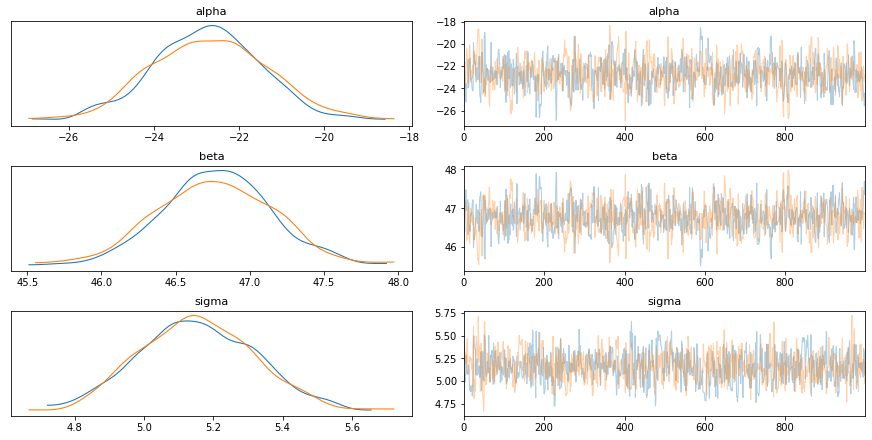

In [85]:
df2 = df
df2 = df2.assign(weight_c=pd.Series(df2.weight - df2.weight.mean()))
with pm.Model() as m4_3:
    alpha = pm.Normal('alpha', mu=178, sd=20)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta * np.log(df2.weight)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=df2.height)

with m4_3:
    trace_4_3 = pm.sample(1000, tune=1000)
    az.plot_trace(trace_4_3);
    trace_df = pm.trace_to_dataframe(trace_4_3)

print(trace_df)

In [86]:
def get_actual_hdi(weight, sample_size=None):
    result = trace_df['alpha'] + trace_df['beta'] * np.log((weight))
    if sample_size is None:
        size = len(result)
    else:
        size = sample_size
    likelihood = stats.norm.rvs(loc=result, scale=trace_df['sigma'], size=sample_size)
    [low_limit, high_limit] = az.hdi(np.array(likelihood), hdi=.97)
    return low_limit, high_limit

def get_hdi_in_point(weight):
    result = trace_df['alpha'] + trace_df['beta'] * np.log((weight))
    [low_limit, high_limit] = az.hdi(np.array(result), hdi=.97)
    return low_limit, high_limit

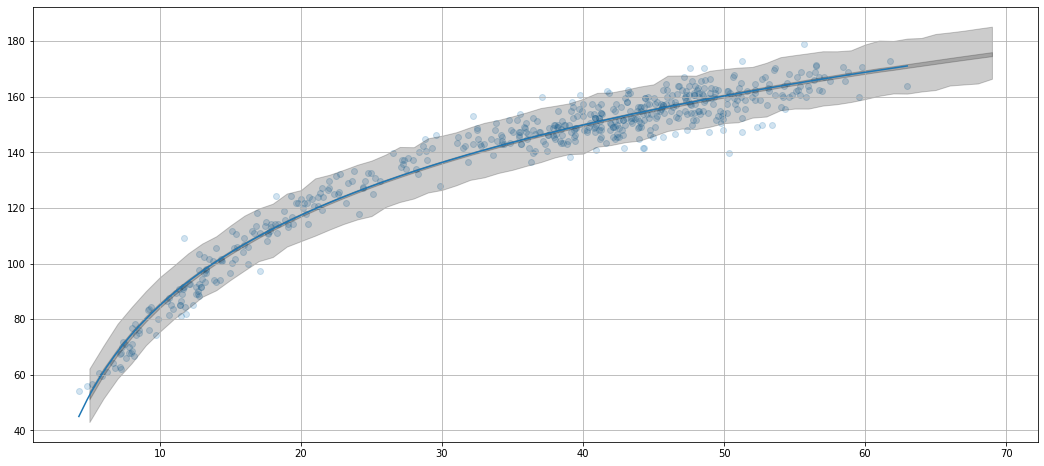

In [87]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figwidth(18)
fig.set_figheight(8)
upper_border = []
lower_border = []

upper_border_actual = []
lower_border_actual = []
weight_range = range(5, 70)
for i in weight_range:
    low_limit, high_limit = get_hdi_in_point(i)
    low_limit_actual, high_limit_actual = get_actual_hdi(i, 2000)
    
    upper_border.append(high_limit)
    lower_border.append(low_limit)
    
    upper_border_actual.append(high_limit_actual)
    lower_border_actual.append(low_limit_actual)

ax.scatter(df2.weight, df2.height, alpha=.2)
ax.plot(np.sort(df2.weight), trace_df['alpha'].mean() + trace_df['beta'].mean() * np.log(np.sort(df2.weight)))
ax.fill_between(weight_range, lower_border, upper_border, alpha=.2, color='black')
ax.fill_between(weight_range, lower_border_actual, upper_border_actual, alpha=.2, color='black')

plt.grid()

Fungsi logaritmik cukup baik dalam menjadi model untuk relasi antara berat dan tinggi. Ini lebih baik dari linear biasa karena sudah memperhitungkan sebelum dewasa dan sesudah dewasa. Bisa dibilang model ini lebih general. 